<a href="https://colab.research.google.com/github/aayush97/GoogleColabPetProjects/blob/master/LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Logistic Regression

In [0]:
#@title
# execute this block when running on google colab
!apt-get install openjdk-8-jdk
!wget https://www-us.apache.org/dist/spark/spark-2.4.3/spark-2.4.3-bin-hadoop2.7.tgz 
!tar xf spark-2.4.3-bin-hadoop2.7.tgz
!pip install findspark
!pip install handyspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.3-bin-hadoop2.7"
from google.colab import drive
drive.mount('/content/drive')
# uncomment the line below if you are running the code on a new drive
# !git clone https://github.com/atosh502/smarter-healthcare.git
%cd /content/drive/My Drive/smarter-healthcare

##Import and initialize

In [0]:
import handyspark
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
sc = SparkContext(master="local[4]")

In [0]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
from pyspark.sql.types import *
from pyspark.ml.classification import LogisticRegression, LogisticRegressionTrainingSummary, LogisticRegressionModel, LogisticRegressionSummary
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
spark = SparkSession.builder.getOrCreate()

##Method definitions

In [0]:
def prepare_data(dataset, feature_cols, label):
  assembler = VectorAssembler(inputCols=feature_cols,outputCol='features')
  data = assembler.transform(dataset)
  return data.select(label,"features")

In [0]:
def fit_and_predict(training, testing):
  lr = LogisticRegression(maxIter=10,regParam=.1,featuresCol="features",labelCol="readmitted")
  model = lr.fit(training)
  return lr,model, model.transform(testing)

In [0]:
def coefficients_and_intercepts(model):
  return str(model.coefficientMatrix), str(model.interceptVector)

In [0]:
def accuracy(predictions):
  correct_predictions = predictions.select("*").where(predictions['readmitted']==predictions['prediction'])
  return correct_predictions.count()/predictions.count()

##Load dataset

In [0]:
#load dataset
dataset_path = "./parquet_files/dataset.parquet"
dataset = spark.read.parquet(dataset_path)
full_features = dataset.drop('readmitted').columns
label = 'readmitted'

##Prune features
Determine best set of attributes by pruning attributes greedily if it increases classification accuracy.
However, a better alternative would be to use best 10 attributes determined by gini-index (top 10 attributes from decision tree)

In [0]:
feature_set = full_features
data = prepare_data(dataset, feature_set, label)
training, testing = data.randomSplit([.7,.3])
_,_,predictions = fit_and_predict(training, testing)
best_accuracy_till_now = accuracy(predictions)
for item in full_features:
  temp_feature_set = feature_set.copy()
  temp_feature_set.remove(item)
  data = prepare_data(dataset, temp_feature_set, label)
  training, testing = data.randomSplit([.7,.3])
  _,_,predictions = fit_and_predict(training, testing)
  acc = accuracy(predictions)
  if(acc>best_accuracy_till_now):
    best_accuracy_till_now = acc
    feature_set = temp_feature_set.copy()

##Evaluate model


In [10]:
# accuray after pruning
print("After pruning:")
full_features = dataset.drop('readmitted').columns
print("length of feature set: ",len(feature_set))
print("accuracy: ", best_accuracy_till_now)

# accuracy before pruning
data = prepare_data(dataset, full_features, label)
training, testing = data.randomSplit([.7,.3])
_,_,predictions = fit_and_predict(training, testing)
print("Before pruning:")
print("length of feature set: ", len(full_features))
print("accuracy: ", accuracy(predictions))

After pruning:
length of feature set:  127
accuracy:  0.6203073993471164
Before pruning:
length of feature set:  130
accuracy:  0.6152175388583452


In [11]:
print("Attributes dropped: ", set(full_features)-set(feature_set))

Attributes dropped:  {'age_[30-40]', 'metformin_Steady', 'num_lab_procedures'}


## Analysis
Logistic regression is a very simple model with a single input and output layer and no hidden layers. From the cell right below we can see that, the model predicts well even in the presence of noise, when one of the attributes perfectly determines the output. However, if there is no perfect correlation, noise largely affects the classification.

<img src="https://sebastianraschka.com/images/faq/logisticregr-neuralnet/schematic.png">


In [12]:
# testing if the classifier performs well when one of the items in the feature set is the label itsef
features_with_label = dataset.columns
data = prepare_data(dataset,features_with_label, label)
training, testing = data.randomSplit([.7, .3])
_,_,predictions = fit_and_predict(training, testing)
print(accuracy(predictions))

0.9994603163895166


##ROC, PRC and Confusion Matrix

In [0]:
data = prepare_data(dataset, feature_set, label)
training, testing = data.randomSplit([.7,.3])
lr, model, predictions = fit_and_predict(training, testing)
bcm = handyspark.BinaryClassificationMetrics(predictions, scoreCol='probability', labelCol='readmitted')

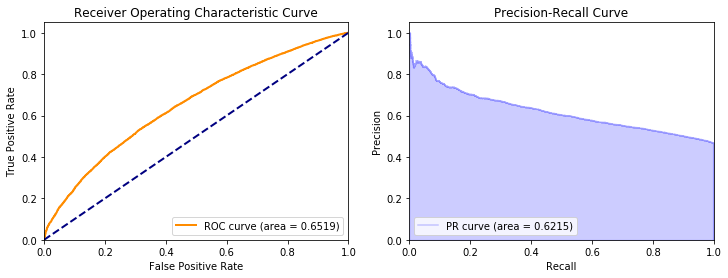

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1])

In [15]:
bcm.print_confusion_matrix(.5)

Predicted        
                 0       1
Actual 0   12233.0  3402.0
       1    7873.0  5801.0

#next steps
1. take only 10 best features determined using gini index. (this features can be obtained from the output of decision-tree classifier) 
2. use the above used greedy approach to further prune from the 10 best features
3. perform significance test on accuracy of present result and the result after performing steps 1 and 2.
4. compare with outputs of decision tree and random forest.